# A Sequence Modeling Pipeline with PyTorch for Weather Prediction
# CENG501 - Spring 2021 - PA3 - Berker Acır - 2098697

In this task, you are expected to experience and demonstrate a pipeline for training a recurrent network.

## 1 Import Modules

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from math import sqrt, inf
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable

if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


## 2 Dataset

We will use the hourly temperature data for Basel (why Basel? because it was freely available) from [meteoblue](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604?daterange=2021-06-01%20-%202021-06-23&domain=NEMSAUTO&params%5B%5D=temp2m&min=2021-06-16&max=2021-06-23&utc_offset=2&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30) between 1 June 2021 and 23 June 2021. Here is a description of how you should prepare your dataset from this raw file:

* Raw data is available [here](http://kovan.ceng.metu.edu.tr/~sinan/DL/Basel_weather.xlsx) as an XLSX file which was downloaded from [meteoblue](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604?daterange=2021-06-01%20-%202021-06-23&domain=NEMSAUTO&params%5B%5D=temp2m&min=2021-06-16&max=2021-06-23&utc_offset=2&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30).

* Load the file into Python as a NumPy array using [Pandas](https://pp4e-book.github.io/chapters/ch10_scientific_libraries.html#data-handling-analysis-with-pandas). Filter out unnecessary information at the top and convert the first column to an hour index, starting at 0 and finishing at 551.

* Split the data into two: A training set from the values between 1 June 2021 and 16 June 2021 (inclusive). A test set from the remaining values.

* For each set, slide a time window of six hours and with a stride of 1, and for each position of the window, create a training input-output pair as follows:

  $(\mathbf{x}_i = <T_i, T_{i+1}, T_{i+2}, T_{i+3}, T_{i+4}>, y_i = T_{i+5}),$
 
  where $T_i$ is the temperature at hour index $i$. 


In [ ]:
# Download the dataset
! if [ ! -f "basel_weather.xlsx" ]; then wget http://kovan.ceng.metu.edu.tr/~sinan/DL/Basel_weather.xlsx -O basel_weather.xlsx; fi

### 2.1 Load Dataset

In [ ]:
xls = pd.ExcelFile('basel_weather.xlsx')
df = xls.parse(skiprows=9)
df = df.rename(columns={df.columns[1]:'temperature'})
df.set_index('timestamp')
df = df.drop_duplicates(subset=df.columns[0])

### 2.2 Visualize Dataset

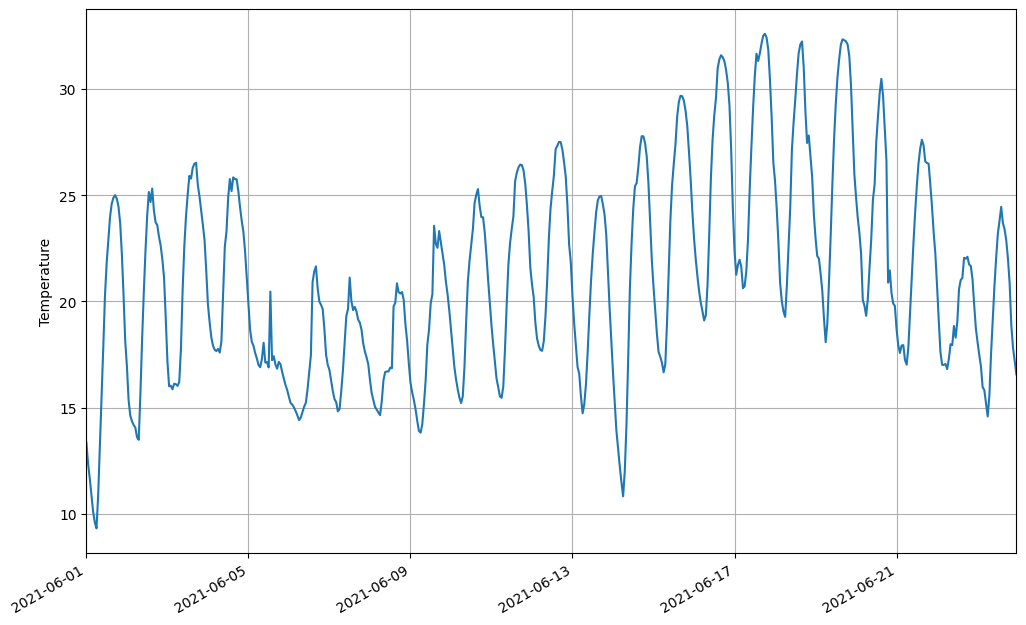

In [ ]:
plt.ylabel('Temperature')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df.timestamp,df.temperature)
plt.gcf().autofmt_xdate()

### 2.3 Split Dataset

In [ ]:
split_date = datetime(2021, 6, 17)

df_train = df.loc[df.timestamp < split_date]
df_test = df.loc[df.timestamp >= split_date]

print(f"Train Dataset: {df_train.size} values between {min(df_train.timestamp)} - {max(df_train.timestamp)}")
print(f"Train Dataset: {df_test.size} values between {min(df_test.timestamp)} - {max(df_test.timestamp)}")

Train Dataset: 768 values between 2021-06-01 00:00:00 - 2021-06-16 23:00:00
Train Dataset: 336 values between 2021-06-17 00:00:00 - 2021-06-23 23:00:00


### 2.3 Training Data

In [ ]:
train_temperatures = df_train.temperature.to_numpy()
test_temperatures = df_test.temperature.to_numpy()

train_data = np.expand_dims(train_temperatures, axis=1)
test_data = np.expand_dims(test_temperatures, axis=1)

In [ ]:
def create_sequences(data, sequence_length): # TODO implement output size and stride 
    input_sequences = []
    output_sequences = []

    for index in range(len(data) - window_size):
        input_sequence = data[index:index + window_size]
        output_sequence = data[index + window_size]
        input_sequences.append(input_sequence)
        output_sequences.append(output_sequence)

    return np.array(input_sequences), np.array(output_sequences) 

window_size = 5
train_input, train_output = create_sequences(train_data, window_size)
test_input, test_output = create_sequences(test_data, window_size)

train_input = torch.from_numpy(train_input).float()
train_output = torch.from_numpy(train_output).float()

test_input = torch.from_numpy(test_input).float()
test_output = torch.from_numpy(test_output).float()

## 3 Your LSTM Definition

Implement your own LSTM "cell" using PyTorch without using PyTorch's LSTM implementation. However, you can use the backpropagation mechanism of PyTorch and therefore, you just need to worry about the feedforward processing.

Your implementation should not be limited to the weather prediction problem and be general. For the sake of simplicity, you can just implement a single-layer LSTM cell.

In [ ]:
# Your LSTM Definition
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        """
          input_size: the size of the input at a time step
          hidden_size: the number of neurons in the hidden state
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.W_xh = nn.Parameter(torch.Tensor(input_size, hidden_size * 4))
        self.W_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_size * 4))

        self.initialize_weights()

    def initialize_weights(self): # TODO try Xavier initialization
        stdv = 1.0 / sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, X, initial_states=None):
        """
          X: A batch of sequences where each sequence has L time steps and for each time step, 
          it has input_size many elements. Has shape (B, L, input_size) with B being 
          the batch size.
          initial_states: Tuple (h_t, c_t) for hidden and cell states.

          Output: Tuple (h, c) where h is the tensor holding the hidden state for L
          time steps, and c is the tensor holding the memory state for L time steps. 
          Both have shape (B, L, hidden_size).
        """
        B, L, input_size = X.size()

        if initial_states is None:
            h_t = Variable(torch.zeros(B, self.hidden_size))
            c_t = Variable(torch.zeros(B, self.hidden_size))
        else:
            h_t, c_t = initial_states

        hidden_states = []

        for t in range(L):
            x_t = X[:, t, :]

            A_t = x_t @ self.W_xh + h_t @ self.W_hh + self.bias
            a_i = A_t[:, :self.hidden_size]
            a_f = A_t[:, self.hidden_size:2*self.hidden_size]
            a_g = A_t[:, 2*self.hidden_size:3*self.hidden_size]
            a_o = A_t[:, 3*self.hidden_size:]

            f_t = torch.sigmoid(a_f) # Forget gate
            i_t = torch.sigmoid(a_i) # Increment gate
            g_t = torch.tanh(a_g) # Feature gate
            o_t = torch.sigmoid(a_o) # Output gate

            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)

            hidden_states.append(h_t.unsqueeze(0))
        
        hidden_states = torch.cat(hidden_states, dim=0)
        hidden_states = hidden_states.transpose(0, 1).contiguous()
        
        return hidden_states, (h_t, c_t)

## 4 Your Sequence Model

In [ ]:
class MyWeatherPredictor(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        
        random.seed(501)
        np.random.seed(501)
        torch.manual_seed(501)

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.lstm = MyLSTM(input_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, X):
        B, L, I = X.size()
        h_0 = Variable(torch.zeros(B, self.hidden_dim))
        c_0 = Variable(torch.zeros(B, self.hidden_dim))
        
        lstm_out, (h_t, _) = self.lstm(X, (h_0, c_0))
        h_t = h_t.view(-1, self.hidden_dim)
        out = self.linear(h_t)
        return out

## 5 Your Trainer

Implement your training function here. You can use functions we have defined in the previous assignments.

In [ ]:
def train_model(train_data, train_labels, test_data=None, test_labels=None, input_size=1, hidden_size=250, learning_rate=1e-3, epochs=200, batch_size=16, verboseEpoch=True, verboseBatch=True):
    model = MyWeatherPredictor(input_size, hidden_size)
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    num_epochs = epochs

    size = len(train_data)
    full_batch_count = size // batch_size
    batch_count = full_batch_count if size % batch_size == 0 else full_batch_count + 1

    train_step_hist = np.zeros(num_epochs * batch_count)
    test_step_hist = np.zeros(num_epochs * batch_count)

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    lowest_test_mse, mse_epoch = float(inf), -1

    for t in range(num_epochs):
        for i in range(batch_count):
            if i == full_batch_count:
                input_batch = train_data[i * batch_size:]
                output_batch = train_labels[i * batch_size:]
            else:
                input_batch = train_data[i * batch_size:(i+1) * batch_size]
                output_batch = train_labels[i * batch_size:(i+1) * batch_size]

            optimizer.zero_grad()

            y_pred = model(input_batch)
            loss = loss_fn(y_pred.float(), output_batch)
            
            if test_data is not None and test_labels is not None:
                with torch.no_grad():
                    y_test_pred = model(test_data)
                    test_loss = loss_fn(y_test_pred.float(), test_labels)
                    test_step_hist[t * batch_count + i] = test_loss.item()
                    if verboseBatch:
                        print(f"Epoch {t} Batch {i} train loss: {loss.item()} test loss: {test_loss.item()}")
            elif verboseBatch:
                print(f"Epoch {t} Batch {i} train loss: {loss.item()}")
            train_step_hist[t * batch_count + i] = loss.item()

            loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            y_pred = model(train_data)
            loss = loss_fn(y_pred.float(), train_output)
            train_hist[t] = loss.item()

            if test_data is not None and test_labels is not None:
                y_test_pred = model(test_data)
                test_loss = loss_fn(y_test_pred.float(), test_labels)
                if test_loss.item() < lowest_test_mse:
                    lowest_test_mse, mse_epoch = test_loss.item(), t
                test_hist[t] = test_loss.item()
                if verboseEpoch:
                    print(f"Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}")
            elif verboseEpoch:
                print(f"Epoch {t} train loss: {loss.item()}")
    
    if verboseEpoch or verboseBatch:
        print(f"Lowest Test MSE: {lowest_test_mse} at Epoch {mse_epoch}")
    return model.eval(), train_hist, test_hist, train_step_hist, test_step_hist, (lowest_test_mse, mse_epoch)

## 6 Train Your Model

Create an instance of your model, a suitable loss function, a suitable optimizer and call the training function with suitable hyperparameters (learning rate, batch size, hidden size etc.).

In [ ]:
model, train_hist, test_hist, train_step_hist, test_step_hist, lowest_mse_info = \
    train_model(train_input, train_output, test_input, test_output, \
                input_size=1,hidden_size=250, learning_rate=1e-2, epochs=50, batch_size=64, \
                verboseEpoch=True, verboseBatch=False)
# print(f"Lowest Test MSE: {lowest_mse_info[0]} at Epoch {lowest_mse_info[1]}")

Epoch 0 train loss: 76.851318359375 test loss: 139.3221893310547
Epoch 1 train loss: 21.859500885009766 test loss: 27.560367584228516
Epoch 2 train loss: 37.29451370239258 test loss: 25.11615753173828
Epoch 3 train loss: 22.313512802124023 test loss: 26.715648651123047
Epoch 4 train loss: 21.883445739746094 test loss: 44.79065704345703
Epoch 5 train loss: 21.950380325317383 test loss: 45.0118293762207
Epoch 6 train loss: 19.994905471801758 test loss: 33.09291076660156
Epoch 7 train loss: 20.627899169921875 test loss: 29.522682189941406
Epoch 8 train loss: 19.97568130493164 test loss: 32.689571380615234
Epoch 9 train loss: 19.866682052612305 test loss: 35.60839080810547
Epoch 10 train loss: 19.77363395690918 test loss: 34.908382415771484
Epoch 11 train loss: 19.92049789428711 test loss: 33.64952087402344
Epoch 12 train loss: 19.905710220336914 test loss: 32.89882278442383
Epoch 13 train loss: 19.66015625 test loss: 33.051570892333984
Epoch 14 train loss: 19.590951919555664 test loss: 33

## 7 Analyze the Results

### 7.1 Visualize the Loss Curve

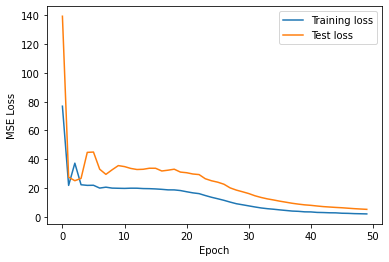

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

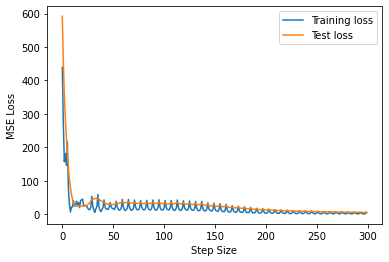

In [ ]:
plt.plot(train_step_hist, label="Training loss")
plt.plot(test_step_hist, label="Test loss")
plt.xlabel('Step Size')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### 7.2 Quantitative Analysis

Provide a quantitative analysis of your model on the test set using root mean squared error.

In [ ]:
with torch.no_grad():
    y_test_pred = model(test_input)
    loss_fn = torch.nn.MSELoss()
    test_loss = loss_fn(y_test_pred.float(), test_output)
    mse = test_loss.item()

    index = 0
    print(f"Sanity check")
    print(f"Input: {test_input[index].view(window_size).tolist()}, Output: {test_output[index][0]}, Prediction: {y_test_pred[index][0]}")
    print(f"\nMSE: {mse}, RMSE: {sqrt(mse)}")

Sanity check
Input: [22.39052963256836, 21.25052833557129, 21.710529327392578, 21.960529327392578, 21.630529403686523], Output: 20.620529174804688, Prediction: 21.78600311279297

MSE: 5.21970272064209, RMSE: 2.284666873012801


### 7.3 Qualitative Analysis

Plot test data and your predictions over a sliding window. Plot two versions of your predictions: (i) Window sliding on the test data and you plot the predictions only. (ii) After obtaining the first prediction on the test data, window sliding over the predictions.

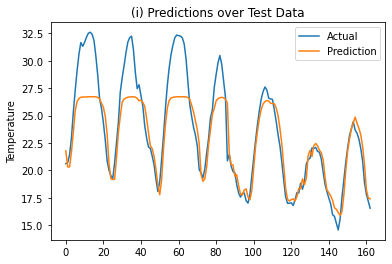

In [ ]:
with torch.no_grad():
    temperatures = test_output.view(-1).tolist()
    predictions = y_test_pred.view(-1).tolist()
    plt.title("(i) Predictions over Test Data")
    plt.plot(temperatures, label="Actual")
    plt.plot(predictions, label="Prediction")
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

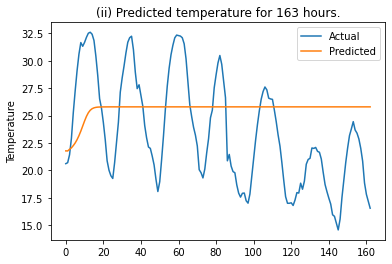

In [ ]:
with torch.no_grad():
    input = test_input[0].view(-1)
    prediction_limit = len(test_input)
    prediction_count = 0
    predictions = []

    while prediction_count < prediction_limit:
        prediction = model(input.view(1, window_size, 1)).view(-1)

        input = input.roll(-1)
        input[-1] = prediction

        predictions.append(prediction)
        prediction_count += 1
    
    if len(test_output) > prediction_count:
        temperatures = test_output.view(-1).tolist()[:prediction_count]
    else:
        temperatures = test_output.view(-1).tolist()
    plt.title(f"(ii) Predicted temperature for {prediction_count} hours.")
    plt.plot(temperatures, label="Actual")
    plt.plot(predictions, label="Predicted")
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

## 8 Tune Your Model

Tune the following aspects for your model and provide a figure or a table in each case:

- Number of hidden neurons.
- Learning rate.
- Batch size.

Report the performance of the best model after tuning.

In [ ]:
hidden_neuron_counts = [64, 128, 256, 512]
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64, 128]
epochs = 500

results = {}
lowest_mse = float(inf)
best_model_key = ""

for lr in learning_rates:
    for bs in batch_sizes:
        for hn in hidden_neuron_counts:
            print(f"Beginning of Learning Rate: {lr}, Batch Size: {bs}, Hidden Neuron Count: {hn}")
            model, train_hist, test_hist, train_step_hist, test_step_hist, lowest_mse_info = \
                train_model(train_input, train_output, test_input, test_output, \
                    input_size=1,hidden_size=hn, learning_rate=lr, epochs=epochs, batch_size=bs, \
                    verboseEpoch=False, verboseBatch=False)
            key = f"lr{lr}_bs{bs}_hn{hn}"
            results[key] = (model, train_hist, test_hist, lowest_mse_info)
            if lowest_mse_info[0] < lowest_mse:
                lowest_mse = lowest_mse_info[0]
                best_model_key = key
            print(f"Ending of Learning Rate: {lr}, Batch Size: {bs}, Hidden Neuron Count: {hn}")

for i in results:
    print(f"{i} - Lowest MSE: {results[i][3][0]} at epoch {results[i][3][1]}.")
print(f"Best Model is {best_model_key} with MSE {lowest_mse}.")

Beginning of Learning Rate: 0.0001, Batch Size: 32, Hidden Neuron Count: 64
Ending of Learning Rate: 0.0001, Batch Size: 32, Hidden Neuron Count: 64
Beginning of Learning Rate: 0.0001, Batch Size: 32, Hidden Neuron Count: 128
Ending of Learning Rate: 0.0001, Batch Size: 32, Hidden Neuron Count: 128
Beginning of Learning Rate: 0.0001, Batch Size: 32, Hidden Neuron Count: 256
Ending of Learning Rate: 0.0001, Batch Size: 32, Hidden Neuron Count: 256
Beginning of Learning Rate: 0.0001, Batch Size: 32, Hidden Neuron Count: 512
Ending of Learning Rate: 0.0001, Batch Size: 32, Hidden Neuron Count: 512
Beginning of Learning Rate: 0.0001, Batch Size: 64, Hidden Neuron Count: 64
Ending of Learning Rate: 0.0001, Batch Size: 64, Hidden Neuron Count: 64
Beginning of Learning Rate: 0.0001, Batch Size: 64, Hidden Neuron Count: 128
Ending of Learning Rate: 0.0001, Batch Size: 64, Hidden Neuron Count: 128
Beginning of Learning Rate: 0.0001, Batch Size: 64, Hidden Neuron Count: 256
Ending of Learning Ra

In [ ]:
for i in results:
    print(f"{i} - Lowest MSE: {results[i][3][0]} at epoch {results[i][3][1]}.")
print(f"Best Model is {best_model_key} with MSE {lowest_mse} at epoch {results[best_model_key][3][1]}.")

lr0.0001_bs32_hn64 - Lowest MSE: 13.7854585647583 at epoch 499.
lr0.0001_bs32_hn128 - Lowest MSE: 2.8493027687072754 at epoch 499.
lr0.0001_bs32_hn256 - Lowest MSE: 1.3782291412353516 at epoch 499.
lr0.0001_bs32_hn512 - Lowest MSE: 0.9288745522499084 at epoch 499.
lr0.0001_bs64_hn64 - Lowest MSE: 51.23679733276367 at epoch 499.
lr0.0001_bs64_hn128 - Lowest MSE: 16.155223846435547 at epoch 499.
lr0.0001_bs64_hn256 - Lowest MSE: 4.237874507904053 at epoch 499.
lr0.0001_bs64_hn512 - Lowest MSE: 2.1119282245635986 at epoch 499.
lr0.0001_bs128_hn64 - Lowest MSE: 134.18031311035156 at epoch 499.
lr0.0001_bs128_hn128 - Lowest MSE: 44.17264938354492 at epoch 499.
lr0.0001_bs128_hn256 - Lowest MSE: 16.000389099121094 at epoch 499.
lr0.0001_bs128_hn512 - Lowest MSE: 4.286960124969482 at epoch 499.
lr0.001_bs32_hn64 - Lowest MSE: 0.7142749428749084 at epoch 499.
lr0.001_bs32_hn128 - Lowest MSE: 0.6746419668197632 at epoch 497.
lr0.001_bs32_hn256 - Lowest MSE: 0.6707124710083008 at epoch 484.
lr0.

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

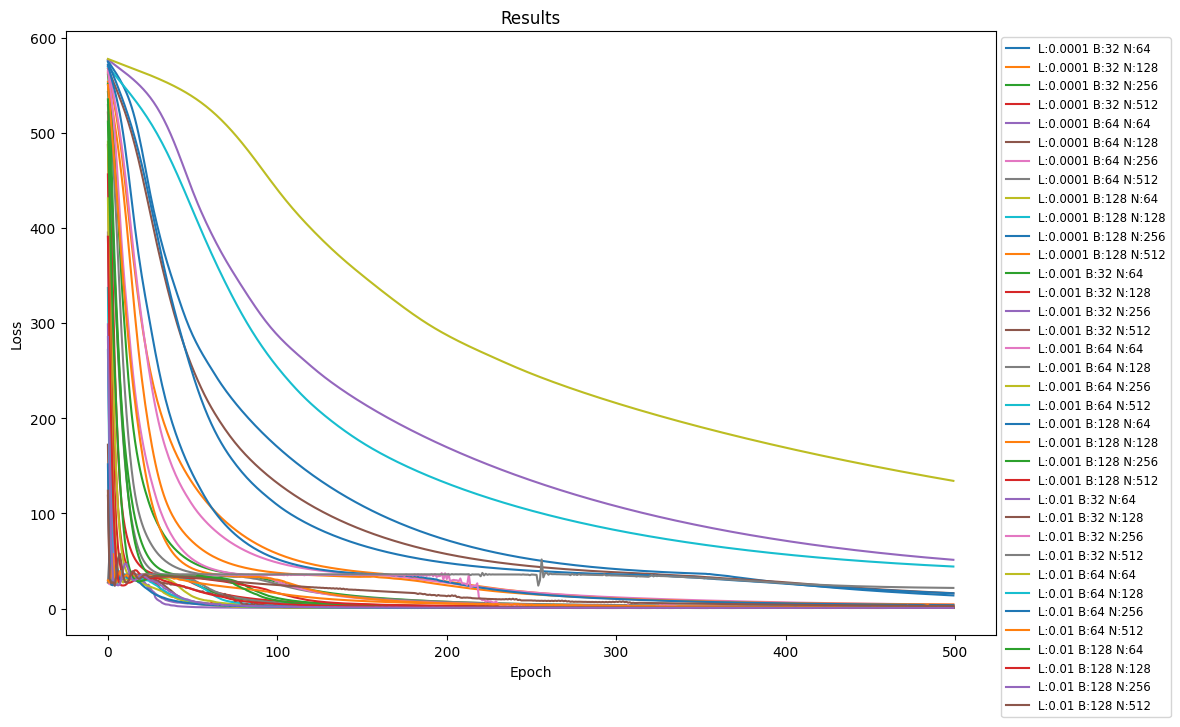

In [ ]:
for key in results:
    label = key.replace("_", " ").replace("lr", "L:").replace("bs", "B:").replace("hn", "N:")
    plt.plot(results[key][2], label=label)
plt.title("Results")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='small')
plt.show()

### 8.1 Learning Rate

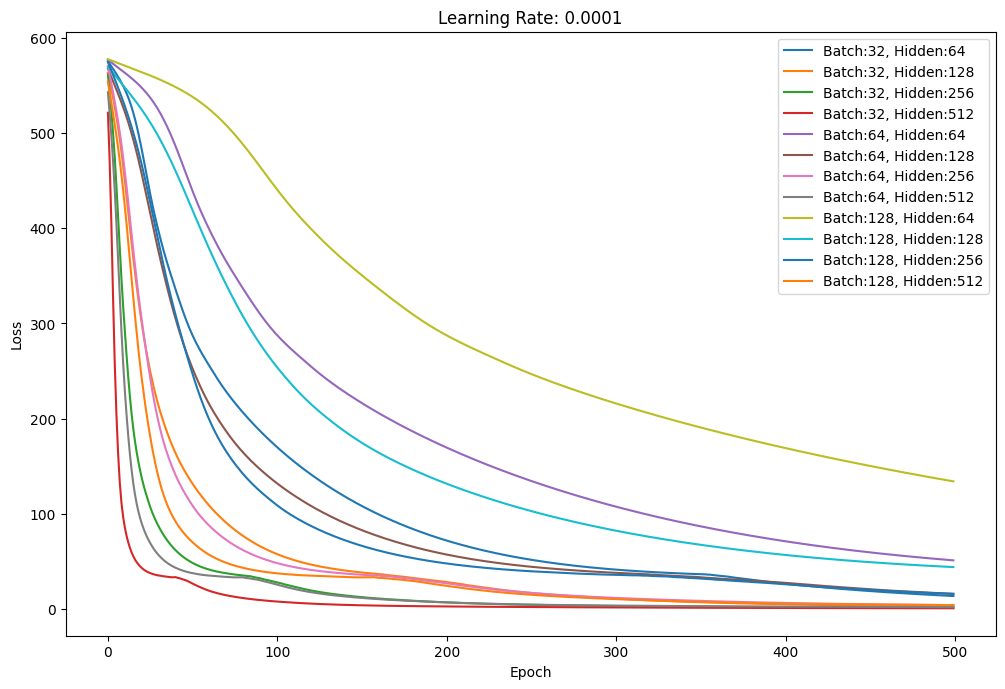

In [ ]:
for key in results:
    if 'lr0.0001' in key:
        splitted_key = key.split("_")
        bs = splitted_key[1].replace("bs", "")
        hn = splitted_key[2].replace("hn", "")
        label = f"Batch:{bs}, Hidden:{hn}"
        plt.plot(results[key][2], label=label)
plt.title("Learning Rate: 0.0001")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

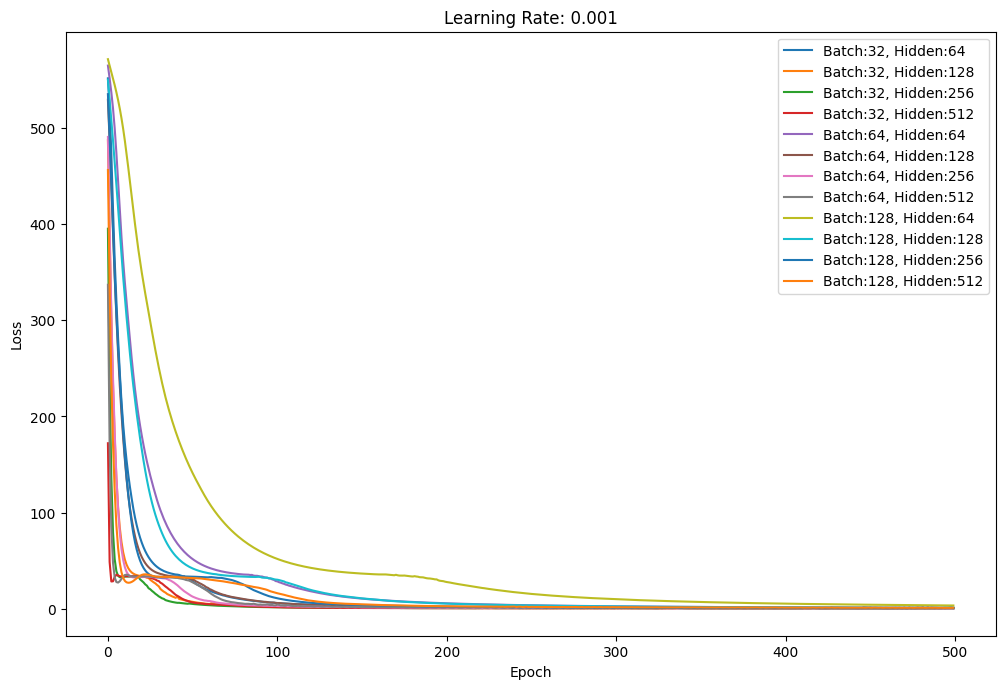

In [ ]:
for key in results:
    if 'lr0.001' in key:
        splitted_key = key.split("_")
        bs = splitted_key[1].replace("bs", "")
        hn = splitted_key[2].replace("hn", "")
        label = f"Batch:{bs}, Hidden:{hn}"
        plt.plot(results[key][2], label=label)
plt.title("Learning Rate: 0.001")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

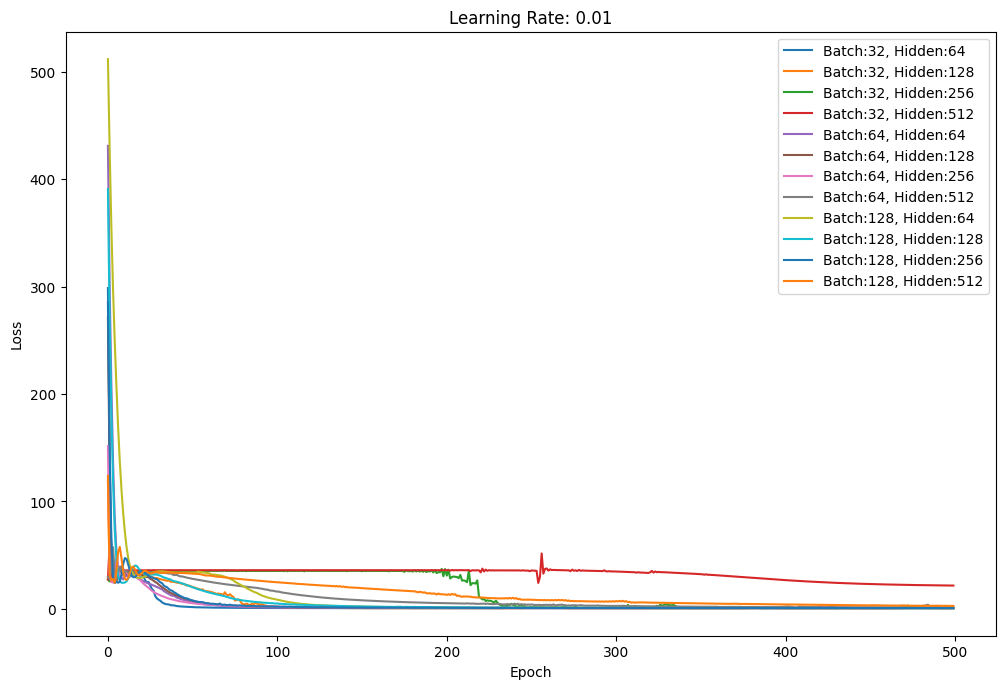

In [ ]:
for key in results:
    if 'lr0.01' in key:
        splitted_key = key.split("_")
        bs = splitted_key[1].replace("bs", "")
        hn = splitted_key[2].replace("hn", "")
        label = f"Batch:{bs}, Hidden:{hn}"
        plt.plot(results[key][2], label=label)
plt.title("Learning Rate: 0.01")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

### 8.2 Batch Size

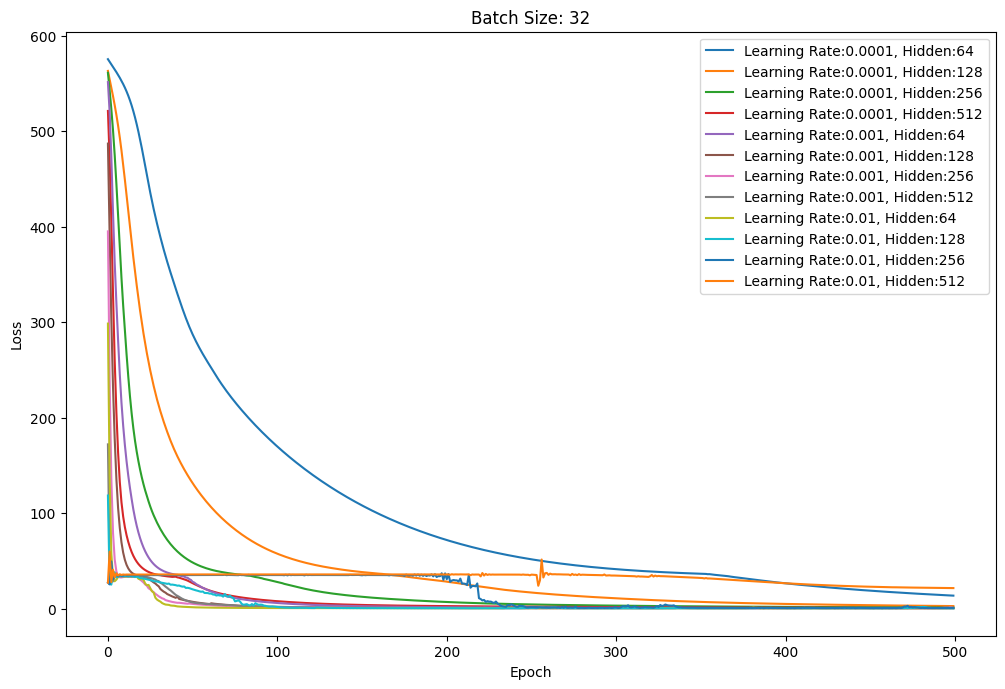

In [ ]:
for key in results:
    if 'bs32' in key:
        splitted_key = key.split("_")
        lr = splitted_key[0].replace("lr", "")
        hn = splitted_key[2].replace("hn", "")
        label = f"Learning:{lr}, Hidden:{hn}"
        plt.plot(results[key][2], label=label)
plt.title("Batch Size: 32")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

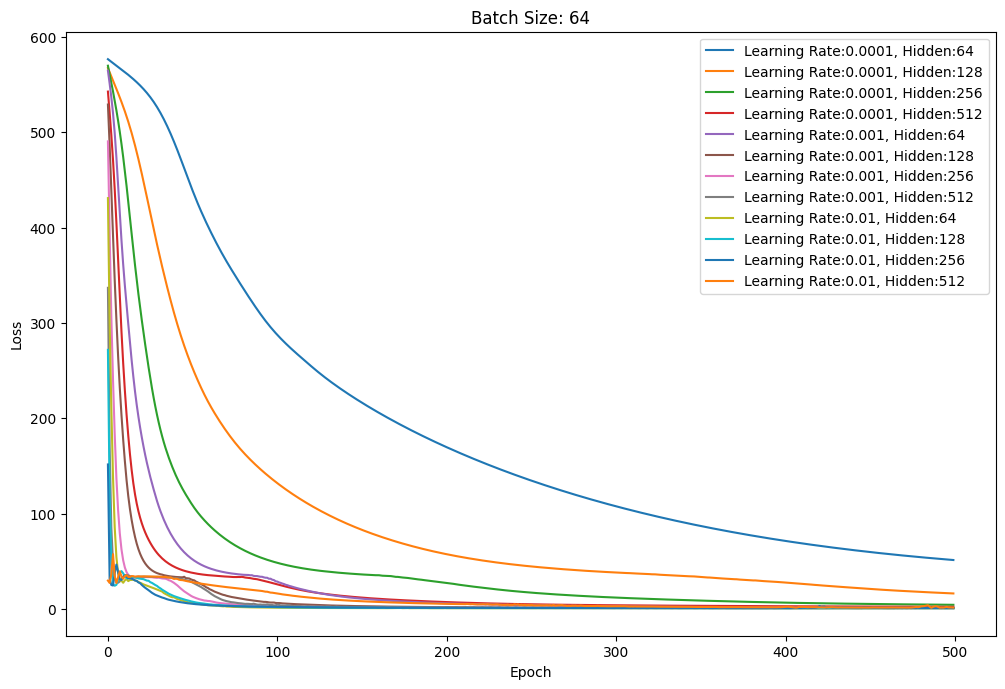

In [ ]:
for key in results:
    if 'bs64' in key:
        splitted_key = key.split("_")
        lr = splitted_key[0].replace("lr", "")
        hn = splitted_key[2].replace("hn", "")
        label = f"Learning:{lr}, Hidden:{hn}"
        plt.plot(results[key][2], label=label)
plt.title("Batch Size: 64")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

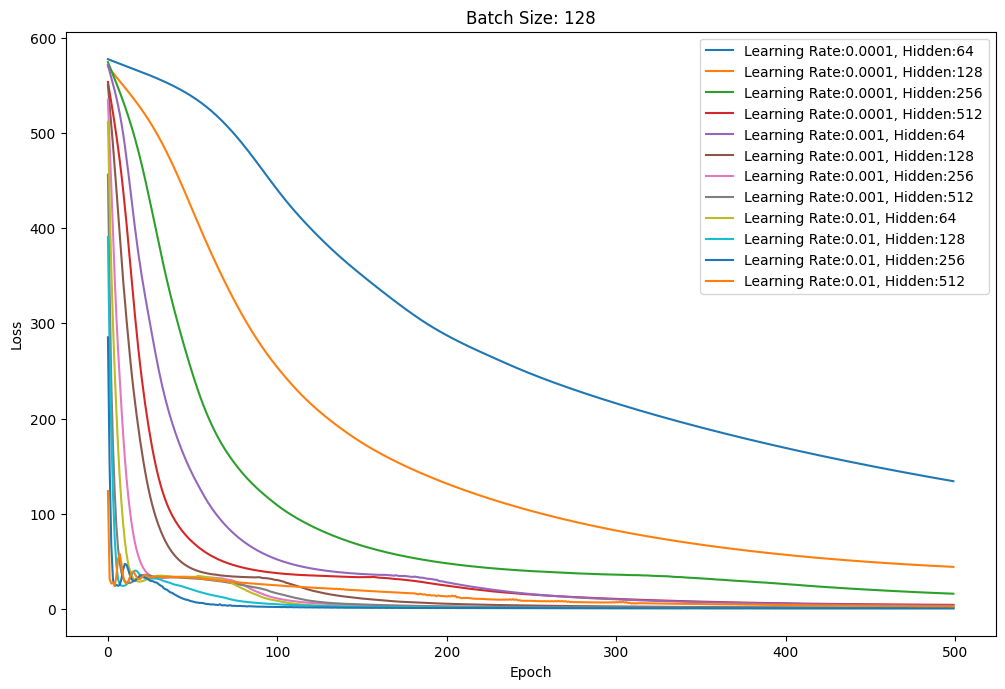

In [ ]:
for key in results:
    if 'bs128' in key:
        splitted_key = key.split("_")
        lr = splitted_key[0].replace("lr", "")
        hn = splitted_key[2].replace("hn", "")
        label = f"Learning:{lr}, Hidden:{hn}"
        plt.plot(results[key][2], label=label)
plt.title("Batch Size: 128")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

### 8.3 Number of Hidden Neurons

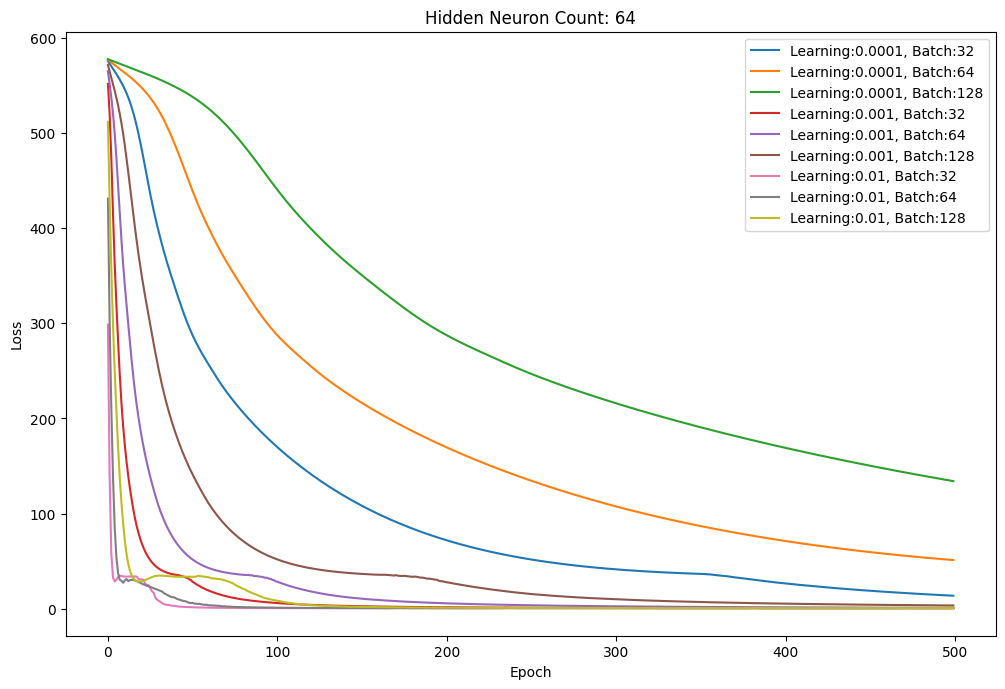

In [ ]:
for key in results:
    if 'hn64' in key:
        splitted_key = key.split("_")
        lr = splitted_key[0].replace("lr", "")
        bs = splitted_key[1].replace("bs", "")
        label = f"Learning:{lr}, Batch:{bs}"
        plt.plot(results[key][2], label=label)
plt.title("Hidden Neuron Count: 64")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

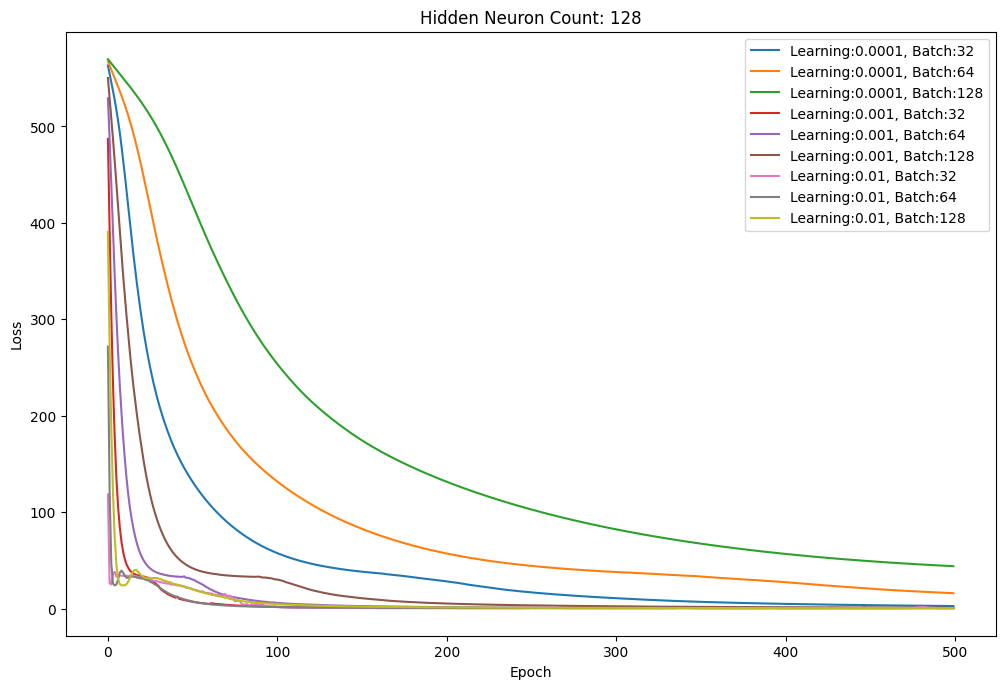

In [ ]:
for key in results:
    if 'hn128' in key:
        splitted_key = key.split("_")
        lr = splitted_key[0].replace("lr", "")
        bs = splitted_key[1].replace("bs", "")
        label = f"Learning:{lr}, Batch:{bs}"
        plt.plot(results[key][2], label=label)
plt.title("Hidden Neuron Count: 128")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

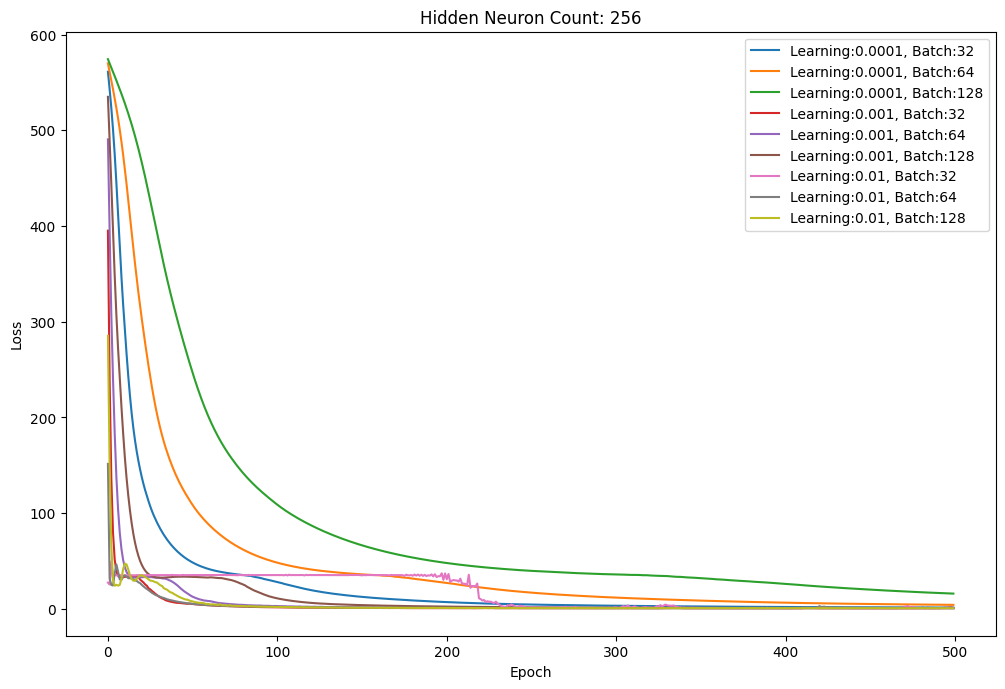

In [ ]:
for key in results:
    if 'hn256' in key:
        splitted_key = key.split("_")
        lr = splitted_key[0].replace("lr", "")
        bs = splitted_key[1].replace("bs", "")
        label = f"Learning:{lr}, Batch:{bs}"
        plt.plot(results[key][2], label=label)
plt.title("Hidden Neuron Count: 256")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

### 8.4 Best Model

From the results, best model has **learning rate of 0.01**, **batch size of 32** and **hidden neuron count of 128** in 500 epochs.

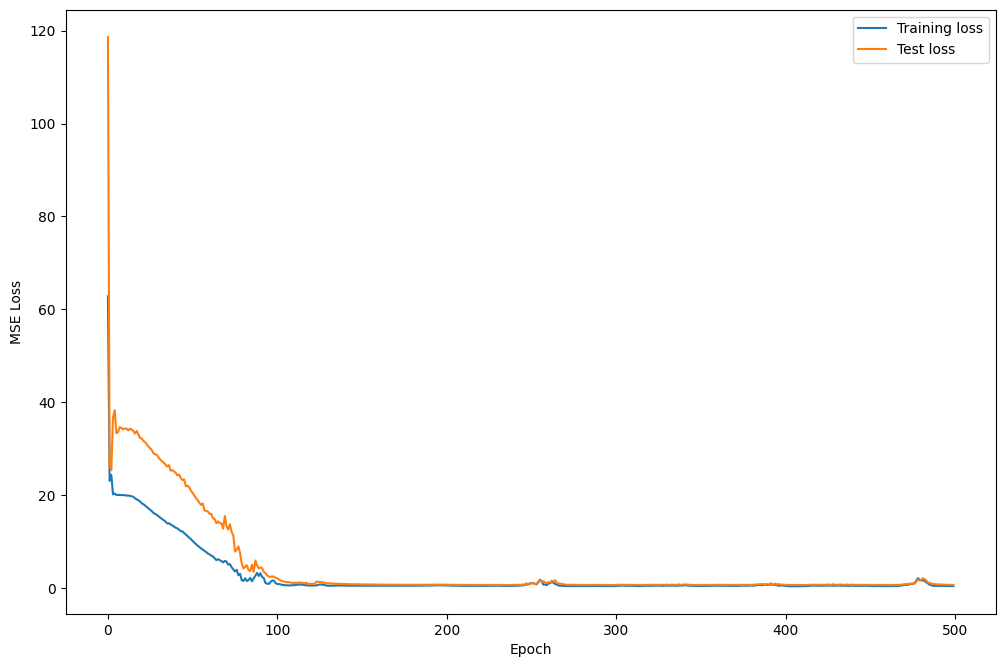

In [ ]:
best_model = results[best_model_key][0]
best_model_train_hist = results[best_model_key][1]
best_model_test_hist = results[best_model_key][2]
plt.plot(best_model_train_hist, label="Training loss")
plt.plot(best_model_test_hist, label="Test loss")
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [ ]:
y_best_model_test_pred = best_model(test_input)
loss_fn = torch.nn.MSELoss()
best_model_test_loss = loss_fn(y_best_model_test_pred.float(), test_output)
mse = best_model_test_loss.item()

index = 0
print(f"Sanity check")
print(f"Input: {test_input[index].view(window_size).tolist()}, Output: {test_output[index][0]}, Prediction: {y_best_model_test_pred[index][0]}")
print(f"\nMSE: {mse}, RMSE: {sqrt(mse)}")

Sanity check
Input: [22.39052963256836, 21.25052833557129, 21.710529327392578, 21.960529327392578, 21.630529403686523], Output: 20.620529174804688, Prediction: 21.53946876525879

MSE: 0.6117250323295593, RMSE: 0.7821285267330168


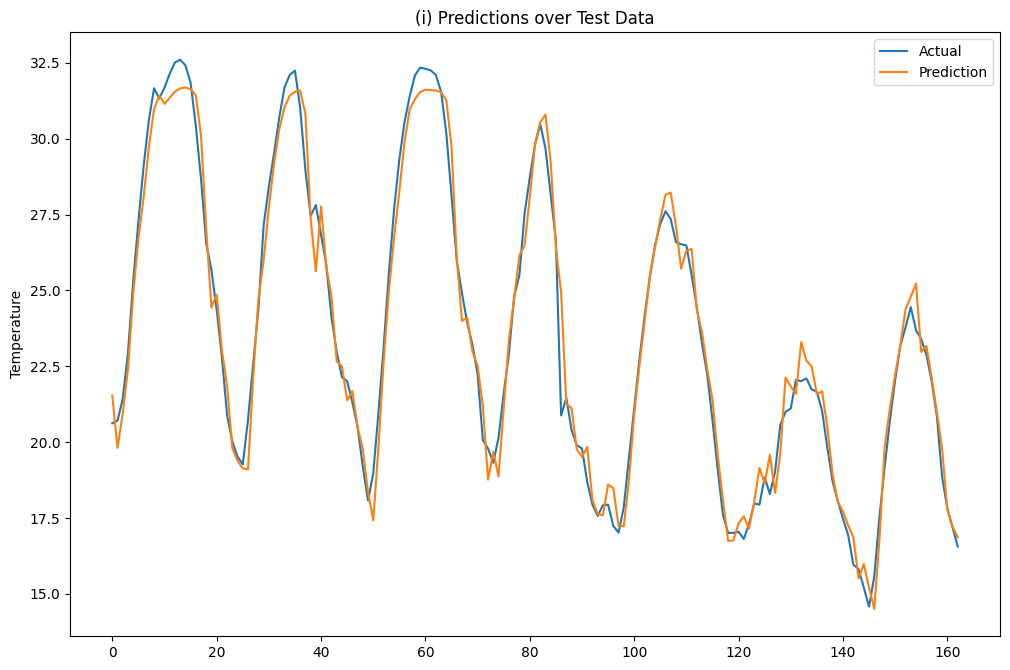

In [ ]:
temperatures = test_output.view(-1).tolist()
best_model_predictions = y_best_model_test_pred.view(-1).tolist()
plt.title("(i) Predictions over Test Data")
plt.plot(temperatures, label="Actual")
plt.plot(best_model_predictions, label="Prediction")
plt.ylabel('Temperature')
plt.legend()
plt.show()

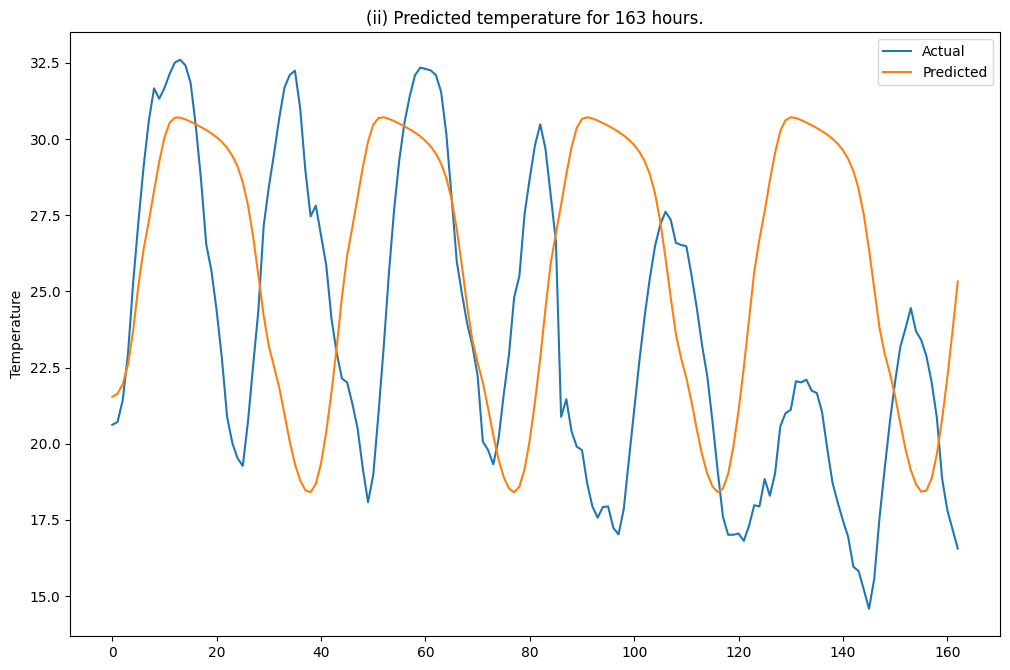

In [ ]:
input = test_input[0].view(-1)
prediction_limit = len(test_input)
best_model_prediction_count = 0
best_model_predictions = []

while best_model_prediction_count < prediction_limit:
    best_model_prediction = best_model(input.view(1, window_size, 1)).view(-1)

    input = input.roll(-1)
    input[-1] = best_model_prediction

    best_model_predictions.append(best_model_prediction)
    best_model_prediction_count += 1

if len(test_output) > best_model_prediction_count:
    temperatures = test_output.view(-1).tolist()[:best_model_prediction_count]
else:
    temperatures = test_output.view(-1).tolist()
plt.title(f"(ii) Predicted temperature for {best_model_prediction_count} hours.")
plt.plot(temperatures, label="Actual")
plt.plot(best_model_predictions, label="Predicted")
plt.ylabel('Temperature')
plt.legend()
plt.show()

It is quite obvious that increasing the model's capacity enhances the model's quality in terms of better and long-lasting predictions. Even though I tried testing different configurations only with 500 epochs, most of the models seem that they can further trained. I will try to train the best model further (2000 epochs) and check it's MSE and RMSE score against the current one.

### 8.5 Further Training

In [ ]:
f_model, f_train_hist, f_test_hist, f_train_step_hist, f_test_step_hist, f_lowest_mse_info = \
    train_model(train_input, train_output, test_input, test_output, \
                input_size=1,hidden_size=128, learning_rate=0.01, epochs=2000, batch_size=32, \
                verboseEpoch=True, verboseBatch=False)

Epoch 0 train loss: 62.78777313232422 test loss: 118.59601593017578
Epoch 1 train loss: 23.03184700012207 test loss: 26.23027992248535
Epoch 2 train loss: 24.32536506652832 test loss: 25.33115005493164
Epoch 3 train loss: 20.108491897583008 test loss: 36.66285705566406
Epoch 4 train loss: 20.320480346679688 test loss: 38.24232864379883
Epoch 5 train loss: 19.965290069580078 test loss: 33.27273178100586
Epoch 6 train loss: 19.99871063232422 test loss: 33.56764221191406
Epoch 7 train loss: 19.98710060119629 test loss: 34.60713195800781
Epoch 8 train loss: 19.978788375854492 test loss: 34.395442962646484
Epoch 9 train loss: 19.958463668823242 test loss: 34.16182327270508
Epoch 10 train loss: 19.934297561645508 test loss: 34.26530075073242
Epoch 11 train loss: 19.8481388092041 test loss: 34.29707336425781
Epoch 12 train loss: 19.877338409423828 test loss: 33.89038848876953
Epoch 13 train loss: 19.78487205505371 test loss: 34.2816047668457
Epoch 14 train loss: 19.68247413635254 test loss: 3

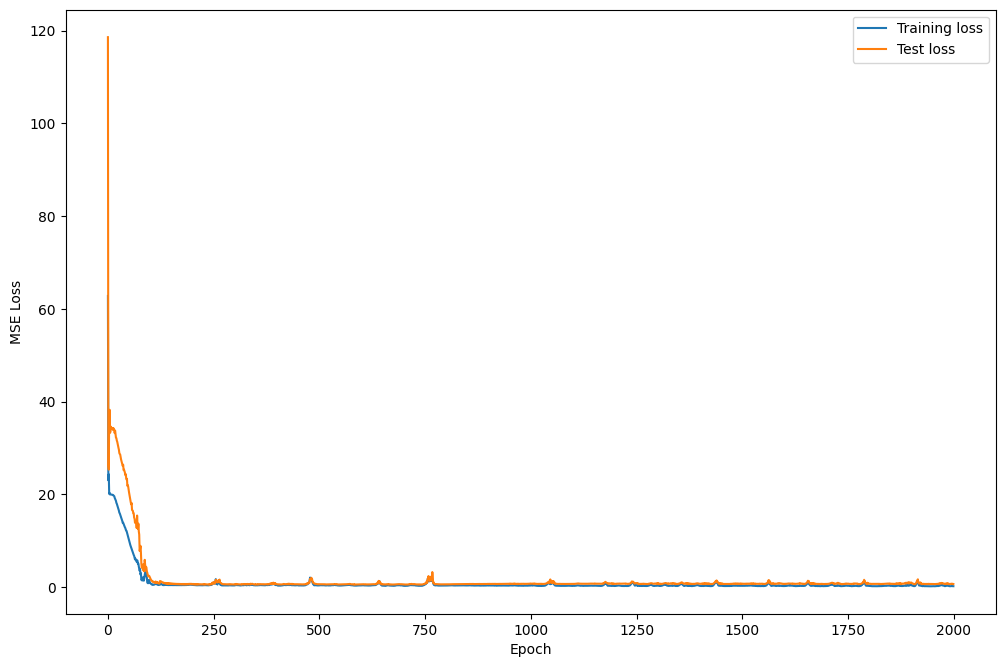

In [ ]:
plt.plot(f_train_hist, label="Training loss")
plt.plot(f_test_hist, label="Test loss")
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [ ]:
f_y_test_pred = f_model(test_input)
loss_fn = torch.nn.MSELoss()
f_test_loss = loss_fn(f_y_test_pred.float(), test_output)
mse = f_test_loss.item()

index = 0
print(f"Sanity check")
print(f"Input: {test_input[index].view(window_size).tolist()}, Output: {test_output[index][0]}, Prediction: {f_y_test_pred[index][0]}")
print(f"\nMSE: {mse}, RMSE: {sqrt(mse)}")

Sanity check
Input: [22.39052963256836, 21.25052833557129, 21.710529327392578, 21.960529327392578, 21.630529403686523], Output: 20.620529174804688, Prediction: 21.39768409729004

MSE: 0.6698657870292664, RMSE: 0.8184532894608381


With 500 epochs, the best model achieved **RMSE 0.7821285267330168** while it achieves **0.8184532894608381 RMSE** with training 2000 epochs. The best achieved MSE is from epoch 593 with **0.5396987795829773 MSE** (RMSE 0.73464193971) which might be the lowest of this model.